# Handwritten Character Recognition
Recognizing handwritten character using Convolutional Neural Network model

## Initialization
Import libraries and initialize functions

### Imports

In [1]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import Subset
from torch import Tensor
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn as nn
import torchvision
import torch
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from datetime import datetime

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

get_time_now = lambda: datetime.fromtimestamp(int(datetime.now().timestamp())).strftime('%H:%M:%S')


cuda


### Memory Management - Class
- Clear GPU cache
- Check status of free and total GPU memory

In [2]:
class GPUMem:
    @staticmethod
    def clear_cache():
        torch.cuda.empty_cache()
        with torch.cuda.device(device): 
            mem_free, mem_total = torch.cuda.mem_get_info()
            print(f'FREE: {mem_free:,}\nTOTAL: {mem_total:,}')

    @staticmethod
    def status():
        with torch.cuda.device(device): 
            mem_free, mem_total = torch.cuda.mem_get_info()
            print(f'FREE: {mem_free:,}\nTOTAL: {mem_total:,}')

GPUMem.status()

FREE: 3,456,892,928
TOTAL: 4,294,508,544


### Dataset Pipeline - Class
- Pre-process and normalize dataset
- Split dataset into training and testing
- Load dataset into batches

In [3]:
class DatasetPipeline:
    def __init__(self, cdata, ddata):
        # Pre-processing - character
        self.cdata = cdata
        self.char_classes = cdata.classes[1:]
        self.char_labels = cdata.targets - 1
        self.char_images = cdata.data.view(len(cdata), 1, 28, 28).float()

        # Pre-processing - digits
        self.ddata = ddata
        self.digit_classes = ddata.classes
        self.digit_labels = ddata.targets
        self.digit_images = ddata.data.view([len(ddata), 1, 28, 28]).float()

        print('ALPHABET')
        print(f'Training samples: {self.char_images.shape[0]:,}; classes: {len(self.char_labels.unique()):,}; shape: {self.char_images.shape}')
        print(f'Classes: {self.char_classes}\n')
        print('DIGITS')
        print(f'Training samples: {self.digit_images.shape[0]:,}; classes: {len(self.digit_labels.unique())}, shape: {self.digit_images.shape}')
        print(f'Classes: {self.digit_classes}\n')

        self.combined_images = None
        self.combined_labels = None
        self.combined_classes = None

        self.train_loader = None
        self.test_loader = None
    
    def prepare(self, num_digits=50_000, num_chars=50_000):
        """Data preparation function
    
        Combines character and digit dataset into one single dataset and normalizes the images.
        
        Args:
            num_digits: Number of digits to sample from total population
            num_chars: Number of character to sample from total population
        Returns:
            None
        """

        # Structure character
        cdata_subset_indicies = np.random.choice(len(self.cdata), num_chars, replace=False)
        self.cdata = Subset(self.cdata, cdata_subset_indicies)
        self.char_labels = torch.tensor([self.cdata.dataset.targets[i] for i in cdata_subset_indicies])
        self.char_images = torch.stack([self.cdata.dataset.data[i] for i in cdata_subset_indicies]).view(len(self.cdata), 1, 28, 28).float()

        # Structure digit
        ddata_subset_indicies = np.random.choice(len(self.ddata), num_digits, replace=False)
        self.ddata = Subset(self.ddata, ddata_subset_indicies)
        self.digit_labels = torch.tensor([self.ddata.dataset.targets[i] for i in ddata_subset_indicies]) + 27
        self.digit_images = torch.stack([self.ddata.dataset.data[i] for i in ddata_subset_indicies]).view(len(self.ddata), 1, 28, 28).float()

        print('ALPHABET')
        print(f'Training - classes: {len(self.char_labels.unique()):,}, shape: {self.char_images.data.shape}')
        print('DIGIT')
        print(f'Training - classes: {len(self.digit_labels.unique()):,}, shape: {self.digit_images.data.shape}')

        # Combine digit and character as one dataset
        self.combined_images = torch.cat((self.digit_images, self.char_images), dim=0)
        self.combined_labels = torch.cat((self.digit_labels, self.char_labels), dim=0) - 1
        self.combined_classes = self.char_classes + self.digit_classes

        # Normalize images
        self.combined_images /= torch.max(self.combined_images)

        print('ALPHABET AND DIGITS')
        print(f'Training - Classes: {len(self.combined_labels.unique()):,}; Shape: {self.combined_images.data.shape}')
        print(f'Classes: {self.combined_classes}')
    
    def augment_images(self, images: Tensor, labels: Tensor) -> tuple[Tensor, Tensor]:
        """Image augmentation function
        
        Transform images by randomly rotating, translating, flipping horizontally and vertically

        Args:
            images: Image dataset with a dimension of 28 by 28 pixels 
            labels: 1D Tensor of corresponding label for images
        Returns:
            tuple: Augmented dataset containing images and labels
        """
        augmentation_transforms = transforms.Compose([
            transforms.RandomRotation(degrees=15), # Randomly rotate images by up to 15 degrees
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), # Random translation by 10% in both x and y directions
            transforms.RandomHorizontalFlip(p=0.5), # Randomly flip images horizontally
            transforms.RandomVerticalFlip(p=0.1), # Randomly flip images vertically
            transforms.ToTensor() # Convert to tensor
        ])

        augmented_images = []
        augmented_labels = []

        for img, label in zip(images, labels):
            img = transforms.ToPILImage()(img) # Convert Tensor to PIL image
            augmented_img = augmentation_transforms(img) # Apply augmentation
            augmented_images.append(augmented_img)
            augmented_labels.append(label)

        augmented_images, augmented_labels = torch.stack(augmented_images), torch.tensor(augmented_labels)
        return augmented_images, augmented_labels
    
    def balance(self, images: Tensor, labels: Tensor, oversampling=True, inplace=True) -> tuple[Tensor, Tensor]:
        """Class balancing
        
        Balances distribution of classes in a dataset

        Args:
            images: Image dataset with a dimension of 28 by 28 pixels 
            labels: 1D Tensor of corresponding label for images
            oversampling: True if minority class should be oversampled
            inplace: True if it should replace current dataset with balanced dataset
        Returns:
            tuple: Balanced dataset containing images and labels
        """

        # Flattened dataset
        image_flat = images.view(images.shape[0], -1).numpy()
        label_flat = labels.numpy()

        print('SHAPE BEFORE SAMPLING')
        print(f'Images: {image_flat.shape}, Labels: {label_flat.shape}')

        # Oversample/Undersample dataset
        sampler = RandomOverSampler() if oversampling else RandomUnderSampler()
        image_sampled, label_sampled = sampler.fit_resample(image_flat, label_flat)

        # Unflattened dataset - bring back to its original shape
        image_sampled = torch.tensor(image_sampled).view(-1, 1, 28, 28).float()
        label_sampled = torch.tensor(label_sampled)

        print('SHAPE AFTER SAMPLING')
        print(f'Images: {image_sampled.shape}, Labels: {label_sampled.shape}')

        if inplace:
            # inplace=True
            self.combined_images = image_sampled
            self.combined_labels = label_sampled
        else:
            # inplace=False
            return image_sampled, label_sampled
    
    def load(self, train_batch_size=32) -> tuple[Tensor, Tensor]:
        """Batch and train-test split function
        
        Split dataset into training and testing. Then load dataset into batches.

        Args:
            train_batch_size: Number of individual training sample per batches
        Returns:
            tuple: Training and testing labels
        """

        # Split dataset into training and testing
        train_data, test_data, train_labels, test_labels = train_test_split(self.combined_images, self.combined_labels, test_size=.1)

        train_data, train_labels = self.balance(images=train_data, labels=train_labels, inplace=False)
        test_data, test_labels = self.balance(images=test_data, labels=test_labels, inplace=False)

        # Convert dataset into Tensor dataset
        tensor_train_data = TensorDataset(train_data, train_labels)
        tensor_test_data = TensorDataset(test_data, test_labels)
        print(f'Training shape: {train_data.shape}, Testing shape: {test_data.shape}')

        # Load dataset into batches
        train_loader = DataLoader(tensor_train_data, batch_size=train_batch_size, shuffle=True, drop_last=True)
        test_loader = DataLoader(tensor_test_data, batch_size=tensor_test_data.tensors[0].shape[0], shuffle=True, drop_last=True)
        print(f'Size of training batches: {len(train_loader)}, testing batches: {len(test_loader)}')

        self.train_loader = train_loader
        self.test_loader = test_loader

        # Returns training and testing labels for visualizing class distribution to ensure balanced class
        return train_labels, test_labels

### Data Visualization - Functions
- Show a single sample of image or randomly show samples of images from the dataset
- Visualize distribution of classes in the dataset
- Visualize loss and error rate per epoch
- Visualize confusion matrix and also output a classification report

In [4]:
def plot_sample_image(
        char_classes: list[str]=None,
        char_images: Tensor=None,
        char_labels: Tensor=None,
        digit_classes: list[str]=None,
        digit_images: Tensor=None,
        digit_labels: Tensor=None,
        img_idx=None,
        is_char=True):
    """Image display function

    Show a single image from the dataset

    Args:
        char_classes: List of unique character classes
        char_images: 2D Tensor image of a character
        char_labels: 1D Tensor label for character
        digit_classes: List of unique digit classes
        digit_images: 2D Tensor image of a digit
        digit_labels: 1D Tensor label for digits
        img_idx: Index of an image from 1D Tensor labels
        is_char: Boolean to indicate if image to show is a character
    Returns:
        None
    """
    if is_char:
        index = np.random.randint(0, char_images.shape[0])
    else:
        index = np.random.randint(0, digit_images.shape[0])

    if img_idx != None:
        index = img_idx

    if is_char:
        sample_image = char_images[index]
        sample_label = char_classes[char_labels[index] - 1]
    else:
        sample_image = digit_images[index]
        sample_label = digit_classes[digit_labels[index] - 27]

    fig = px.imshow(sample_image.numpy()[
                    0].T, title=f'Class: {sample_label}', color_continuous_scale='gray')
    fig.update_layout(width=400, height=400,
                        margin=dict(l=40, r=40, b=40, t=40))
    fig.update_xaxes(showticklabels=False).update_yaxes(
        showticklabels=False)
    fig.show()

def plot_sample_images(
        char_classes: list[str]=None,
        char_images: Tensor=None,
        char_labels: Tensor=None,
        digit_classes: list[str]=None,
        digit_images: Tensor=None,
        digit_labels: Tensor=None,
        num_images=10,
        is_char=True):
    """Image display function

    Randomly select and show multiple image samples from the dataset

    Args:
        char_classes: List of unique character classes
        char_images: 2D Tensor image of a character
        char_labels: 1D Tensor label for character
        digit_classes: List of unique digit classes
        digit_images: 2D Tensor image of a digit
        digit_labels: 1D Tensor label for digits
        num_images: Number of image samples to show
        is_char: Boolean to indicate if image to show is from the character dataset
    Returns:
        None
    """

    if is_char:
        indices = np.random.choice(
            char_images.shape[0], num_images, replace=False)
    else:
        indices = np.random.choice(
            digit_images.shape[0], num_images, replace=False)

    _, axes = plt.subplots(1, num_images, figsize=(16, 16))
    for ax, idx in zip(axes.flatten(), indices):
        if is_char:
            image = char_images[idx]
            label = char_classes[char_labels[idx] - 1]
        else:
            image = digit_images[idx]
            label = digit_classes[digit_labels[idx] - 27]

        ax.imshow(image.numpy().T, cmap='gray')
        ax.set_title(f'{label}')
        ax.axis("off")

    plt.tight_layout()
    plt.show()

def plot_sample_combine_images(classes: list[str], images: Tensor, labels: Tensor, num_images=10):
    """Image display function

    Randomly select and show multiple image samples from the dataset

    Args:
        classes: List of classes in the dataset
        images: Image dataset with a dimension of 28 by 28 pixels
        labels: 1D Tensor of corresponding label for images
        num_images: Number of image samples to show
    Returns:
        None
    """

    indices = np.random.choice(images.shape[0], num_images, replace=False)

    _, axes = plt.subplots(1, num_images, figsize=(16, 16))
    for ax, idx, in zip(axes.flatten(), indices):
        image = images[idx]
        label = classes[labels[idx]]
    
        ax.imshow(image.numpy().T, cmap='gray')
        ax.set_title(f'{label}')
        ax.axis("off")

    plt.tight_layout()
    plt.show()

def plot_class_distribution(labels: Tensor, classes: list[str], class_type='char'):
    """Visualize class distribution

    Visualize class distribution of character and digit images

    Args:
        classes: List of classes in the dataset
        labels: 1D Tensor label of class
        class_type: Type of dataset to show (char for Characters, digit for Digits, digitchar for Character and digits)
    Returns:
        None
    """

    x_labels, y_counts = np.unique(labels, return_counts=True)

    if class_type == 'char':
        x = [classes[i - 1] for i in x_labels]
        title = f'Distribution of character images'
    elif class_type == 'digit':
        x = [classes[i - 27] for i in x_labels]
        title = f'Distribution of character images'
    elif class_type == 'digitchar':
        x = [classes[i] for i in x_labels]
        title = f'Distribution of character and digit images'

    go.Figure(data=[
        go.Bar(x=x, y=y_counts, text=y_counts, textposition='auto',)
    ]).update_layout(title=title, xaxis_title='Class', yaxis_title='Count'
    ).show()

def plot_model_performance(train_loss: list, test_loss: list, train_error: list, test_error: list):
    """Train-test loss and train-test error

    Visualize the loss and error rate for both training and testing dataset per epoch

    Args:
        train_loss: List of loss value per epoch for training dataset
        test_loss: List of loss value per epoch for testing dataset
        train_error: List of error rate per epoch for training dataset
        test_error: List of error rate per epoch for testing dataset
    Returns:
        None
    """

    train_loss_df = pd.DataFrame(train_loss, columns=['Train'])
    test_loss_df = pd.DataFrame(test_loss, columns=['Test'])

    train_err_df = pd.DataFrame(train_error, columns=['Train'])
    test_err_df = pd.DataFrame(test_error, columns=['Test'])

    df_loss = pd.concat([train_loss_df, test_loss_df], axis=1)
    px.line(
        df_loss,
        markers=True,
        title=f'Final train loss: {train_loss[-1]:.2f}, test loss: {test_loss[-1]:.2f}',
        labels={'index': 'Epochs', 'value': 'Loss (MSE)'}) \
        .update_traces(textposition="bottom right").show()

    df_err = pd.concat([train_err_df, test_err_df], axis=1)
    px.line(
        df_err,
        markers=True,
        title=f'Final test error rate: {test_error[-1]:.2f}%',
        labels={'index': 'Epochs', 'value': 'Error rates (%)'}) \
        .update_traces(textposition="bottom right").show()

def plot_classif_report(actual: list, prediction: list, classes: list[str]):
    """Classification report and confusion matrix

    Visualizes confusion matrix for actual ground truth labels and predicted labels\n
    Then output a classification report

    Args:
        actual: List of the actual ground truth labels
        prediction: List of predicted labels
        classes: List of classes in the dataset
    Returns:
        None
    """

    cm = confusion_matrix(actual, prediction)

    plt.figure(figsize=(16, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)

    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    print(classification_report(actual, prediction, target_names=classes))


### Model Architecture - Class
- Structure of CNN model
- Function for training and evaluating a model

In [5]:
class CNNModel(nn.Module):
    def __init__(self, printtoggle, output_layers):
        super().__init__()
        self.print = printtoggle

        # First Convolution Layer: (Input channel, output channels, kernel size)
        self.conv1 = nn.Conv2d(1, 6, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(6)

        # Second Convolution Layer: (Input channel, output channels, kernel size)
        self.conv2 = nn.Conv2d(6, 6, 3, padding=1)
        self.bnorm2 = nn.BatchNorm2d(6)

        # Neural Network Input Layer: Input neurons to hidden neurons
        self.fc1 = nn.Linear(7 * 7 * 6, 50)
        # Neural Network Hidden Layer: Hidden neurons to output neurons
        self.fc2 = nn.Linear(50, output_layers)

    def forward(self, x):
        if self.print:
            print(f'Input: {list(x.shape)}')

        # First Block: Convolution -> Max Pooling -> Batch Normalization -> Relu Activation
        x = F.max_pool2d(self.conv1(x), 2) # Kernel size = 2, Stride = 2
        x = F.leaky_relu(self.bnorm1(x))
        if self.print:
            print(f'First CPR block: {list(x.shape)}')

        # Second Block: Convolution -> Max Pooling -> Batch Normalization -> Relu Activation
        x = F.max_pool2d(self.conv2(x), 2) # Kernel size = 2, Stride = 2
        x = F.leaky_relu(self.bnorm2(x))
        if self.print:
            print(f'Second CPR block: {list(x.shape)}')

        # Reshapes the (7x7) 6 feature map to 7 x 7 x 6 input features for Neural Network
        n_units = x.shape.numel() / x.shape[0]
        x = x.view(-1, int(n_units))
        if self.print:
            print(f'Vectorized: {list(x.shape)}')

        # Neural Network Input Layer: Input neurons to hidden neurons
        x = F.leaky_relu(self.fc1(x))
        # Neural Network Hidden Layer: Hidden neurons to output neurons
        x = self.fc2(x)
        if self.print:
            print(f'Final output: {list(x.shape)}')
        
        return x

class TrainEvalModel:

    @staticmethod
    def train_model(train_char_loader: DataLoader, test_char_loader: DataLoader, model: CNNModel, num_epochs=10):
        lossfun = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=.001)

        # Send model to GPU
        model.to(device)

        train_loss = torch.zeros(num_epochs)
        test_loss = torch.zeros(num_epochs)
        train_error = torch.zeros(num_epochs)
        test_error = torch.zeros(num_epochs)

        for epoch in range(num_epochs):
            model.train()
            batch_loss = []
            batch_error = []

            # Forward and backward propagate for all batches
            for x, y in train_char_loader:
                # Push data to GPU
                x = x.to(device)
                y = y.to(device)

                # Forward progagate and calculate loss
                y_hat = model(x)
                loss = lossfun(y_hat, y)

                # Backward propagate and update parameters
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Append loss and error from this batch
                batch_loss.append(loss.item())
                batch_error.append(torch.mean((torch.argmax(y_hat, axis=1) != y).float()).item())

            # Get average losses and error rates across the batches from training data
            train_loss[epoch] = np.mean(batch_loss)
            train_error[epoch] = 100 * np.mean(batch_error)
            train_loss_err_msg = f'TRAIN LOSS: {train_loss[epoch]:_.2f}, TRAIN ERR: {train_error[epoch]:_.2f}'

            # Forward propagate on testing data to calculate test loss and test error
            model.eval()
            x_test, y_test = next(iter(test_char_loader))
            x_test = x_test.to(device)
            y_test = y_test.to(device)

            with torch.no_grad():
                y_hat_test = model(x_test)
                lossfun_test = lossfun(y_hat_test, y_test)

            # Get average losses and error rates from testing data
            test_loss[epoch] = lossfun_test.item()
            test_error[epoch] = 100 * torch.mean((torch.argmax(y_hat_test, axis=1)!= y_test).float()).item()
            test_loss_err_msg = f'TEST LOSS: {test_loss[epoch]:_.2f}, TEST ERR: {test_error[epoch]:_.2f}'

            print(f'{epoch}, ' + train_loss_err_msg + ', ' + test_loss_err_msg)

        return train_loss, test_loss, train_error, test_error, model

    @staticmethod
    def evaluate_model(test_loader: DataLoader, classes: list[str], model: CNNModel):
        model.eval()
        all_preds = []
        all_labels = []

        x_test, y_test = next(iter(test_loader))
        x_test = x_test.to(device)
        y_test = y_test.to(device)

        with torch.no_grad():
            y_hat_test = model(x_test)
            preds = torch.argmax(y_hat_test, axis=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_test.cpu().numpy())        
        
        plot_classif_report(all_labels, all_preds, classes)
    

## Entrypoint
After importing libraries, datasets and initializing functions, proceed to:
- Data preparation
    - Exploratory Data Analysis
- Model Training
- Evaluation and prediction

### Data Preparation

#### Download

In [6]:
dataset = DatasetPipeline(
    cdata=torchvision.datasets.EMNIST(root='emnist', split='letters', download=True),
    ddata=torchvision.datasets.EMNIST(root='emnist', split='digits', download=True)
)

ALPHABET
Training samples: 124,800; classes: 26; shape: torch.Size([124800, 1, 28, 28])
Classes: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

DIGITS
Training samples: 240,000; classes: 10, shape: torch.Size([240000, 1, 28, 28])
Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']



#### Normalization

In [7]:
dataset.prepare(num_digits=100_000, num_chars=100_000)

ALPHABET
Training - classes: 26, shape: torch.Size([100000, 1, 28, 28])
DIGIT
Training - classes: 10, shape: torch.Size([100000, 1, 28, 28])
ALPHABET AND DIGITS
Training - Classes: 36; Shape: torch.Size([200000, 1, 28, 28])
Classes: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


#### EDA

##### Alphabet

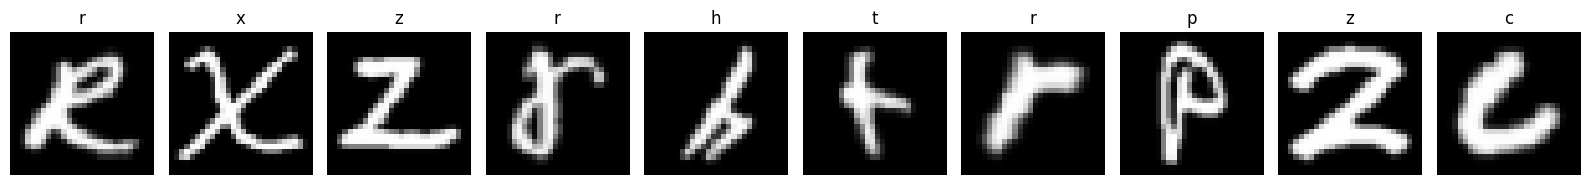

In [8]:
plot_class_distribution(labels=dataset.char_labels, classes=dataset.char_classes, class_type='char')
plot_sample_images(char_classes=dataset.char_classes, char_images=dataset.char_images, char_labels=dataset.char_labels)

In [9]:
np.set_printoptions(linewidth=150)
print('Label:', dataset.char_classes[dataset.char_labels[800] - 1])
print('Matrix:\n', dataset.char_images[800].numpy()[0].T)
plot_sample_image(char_classes=dataset.char_classes, char_images=dataset.char_images, char_labels=dataset.char_labels, img_idx=800)

Label: b
Matrix:
 [[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   1.  20.  37.  37.  37.  37.  21.   5.   4.   4.   4.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.  33. 158. 215. 217. 217. 215. 172. 129. 127. 125. 114.  51.  32.   8.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   6.  18. 106. 237. 254. 254. 254. 254. 252. 250. 250. 249. 245. 222. 204. 126.  33.   8.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   7.  88. 144. 122. 165. 215. 217. 217. 217. 217. 217. 222. 245. 249. 250. 253. 244. 163.  91.   8.   0.   0.   0.   0.]
 [  0.   0.   0.   0.  32. 202. 242. 208.  66.  37.  37.  37.  37.  37.  37.  51. 114. 126. 140. 209. 249. 246. 218.  77.   

##### Digits

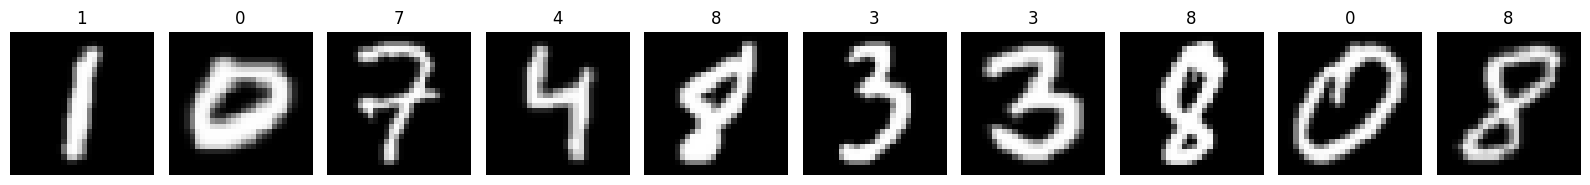

In [10]:
plot_class_distribution(labels=dataset.digit_labels, classes=dataset.digit_classes, class_type='digit')
plot_sample_images(digit_classes=dataset.digit_classes, digit_images=dataset.digit_images, digit_labels=dataset.digit_labels, is_char=False)

In [11]:
np.set_printoptions(linewidth=150)
print('Label:', dataset.digit_classes[dataset.digit_labels[800] - 27])
print('Matrix:\n', dataset.digit_images[800].numpy()[0].T)
plot_sample_image(digit_classes=dataset.digit_classes, digit_images=dataset.digit_images, digit_labels=dataset.digit_labels, img_idx=800, is_char=False)

Label: 7
Matrix:
 [[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   2.   4.   4.   4.   4.   4.   4.   2.   0.   2.   3.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   7.  22.  82. 114. 127. 127. 127. 127. 114.  82.  41.  80. 100.  32.   7.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   1.   9.  90. 159. 232. 245. 250. 250. 250. 250. 245. 233. 218. 233. 236. 113.  32.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   8.  35. 163. 218. 251. 251. 250. 250. 252. 253. 254. 252. 250. 252. 248. 125.  37.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   2.  77. 158. 245. 252. 221. 177. 129. 129. 172. 204. 236. 249. 255. 253. 243. 113.  3

##### Alphabet and Digits
Distribution of character and digit images

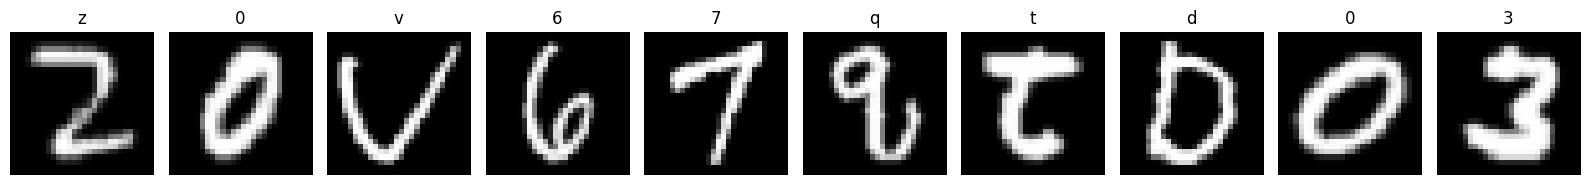

In [13]:
plot_class_distribution(labels=dataset.combined_labels, classes=dataset.combined_classes, class_type='digitchar')
plot_sample_combine_images(classes=dataset.combined_classes, images=dataset.combined_images, labels=dataset.combined_labels)

#### Balancing and Loading
- Balance the porportion of classes in the dataset
- Split dataset into training and testing set
- Load dataset into batches using data loader

In [14]:
# Balance the porportion of classes in the dataset
dataset.balance(images=dataset.combined_images, labels=dataset.combined_labels, oversampling=True, inplace=True)
plot_class_distribution(labels=dataset.combined_labels, classes=dataset.combined_classes, class_type='digitchar')

SHAPE BEFORE SAMPLING
Images: (200000, 784), Labels: (200000,)
SHAPE AFTER SAMPLING
Images: torch.Size([364536, 1, 28, 28]), Labels: torch.Size([364536])


In [15]:
# Split dataset into training and testing set
# Load dataset into batches using data loader
train_labels_proportions, test_labels_proportion = dataset.load()
plot_class_distribution(labels=train_labels_proportions, classes=dataset.combined_classes, class_type='digitchar')
plot_class_distribution(labels=test_labels_proportion, classes=dataset.combined_classes, class_type='digitchar')

SHAPE BEFORE SAMPLING
Images: (328082, 784), Labels: (328082,)
SHAPE AFTER SAMPLING
Images: torch.Size([330372, 1, 28, 28]), Labels: torch.Size([330372])
SHAPE BEFORE SAMPLING
Images: (36454, 784), Labels: (36454,)
SHAPE AFTER SAMPLING
Images: torch.Size([38700, 1, 28, 28]), Labels: torch.Size([38700])
Training shape: torch.Size([330372, 1, 28, 28]), Testing shape: torch.Size([38700, 1, 28, 28])
Size of training batches: 10324, testing batches: 1


### Model Training

In [16]:
model1 = CNNModel(printtoggle=False, output_layers=36)

train_cd_loss, test_cd_loss, train_cd_error, test_cd_error, net_cd = TrainEvalModel.train_model(
    train_char_loader=dataset.train_loader, test_char_loader=dataset.test_loader, model=model1, num_epochs=20)

0, TRAIN LOSS: 0.54, TRAIN ERR: 17.82, TEST LOSS: 0.40, TEST ERR: 13.76
1, TRAIN LOSS: 0.38, TRAIN ERR: 13.32, TEST LOSS: 0.36, TEST ERR: 13.22
2, TRAIN LOSS: 0.34, TRAIN ERR: 12.46, TEST LOSS: 0.35, TEST ERR: 12.61
3, TRAIN LOSS: 0.33, TRAIN ERR: 11.91, TEST LOSS: 0.34, TEST ERR: 12.36
4, TRAIN LOSS: 0.31, TRAIN ERR: 11.49, TEST LOSS: 0.33, TEST ERR: 12.00
5, TRAIN LOSS: 0.31, TRAIN ERR: 11.23, TEST LOSS: 0.31, TEST ERR: 11.44
6, TRAIN LOSS: 0.30, TRAIN ERR: 11.05, TEST LOSS: 0.32, TEST ERR: 11.57
7, TRAIN LOSS: 0.29, TRAIN ERR: 10.84, TEST LOSS: 0.31, TEST ERR: 11.04
8, TRAIN LOSS: 0.29, TRAIN ERR: 10.67, TEST LOSS: 0.31, TEST ERR: 10.98
9, TRAIN LOSS: 0.28, TRAIN ERR: 10.60, TEST LOSS: 0.31, TEST ERR: 11.13
10, TRAIN LOSS: 0.28, TRAIN ERR: 10.49, TEST LOSS: 0.29, TEST ERR: 10.59
11, TRAIN LOSS: 0.28, TRAIN ERR: 10.33, TEST LOSS: 0.30, TEST ERR: 10.64
12, TRAIN LOSS: 0.27, TRAIN ERR: 10.29, TEST LOSS: 0.30, TEST ERR: 10.82
13, TRAIN LOSS: 0.27, TRAIN ERR: 10.17, TEST LOSS: 0.29, TEST

In [52]:
# Save the model's parameters
torch.save(model1.state_dict(), 'models\model2.pth')

### Evaluation

#### Loss and Error

In [17]:
plot_model_performance(train_cd_loss, test_cd_loss, train_cd_error, test_cd_error)

#### Confusion Matrix and Report
Confusion matrix and classification report for testing dataset

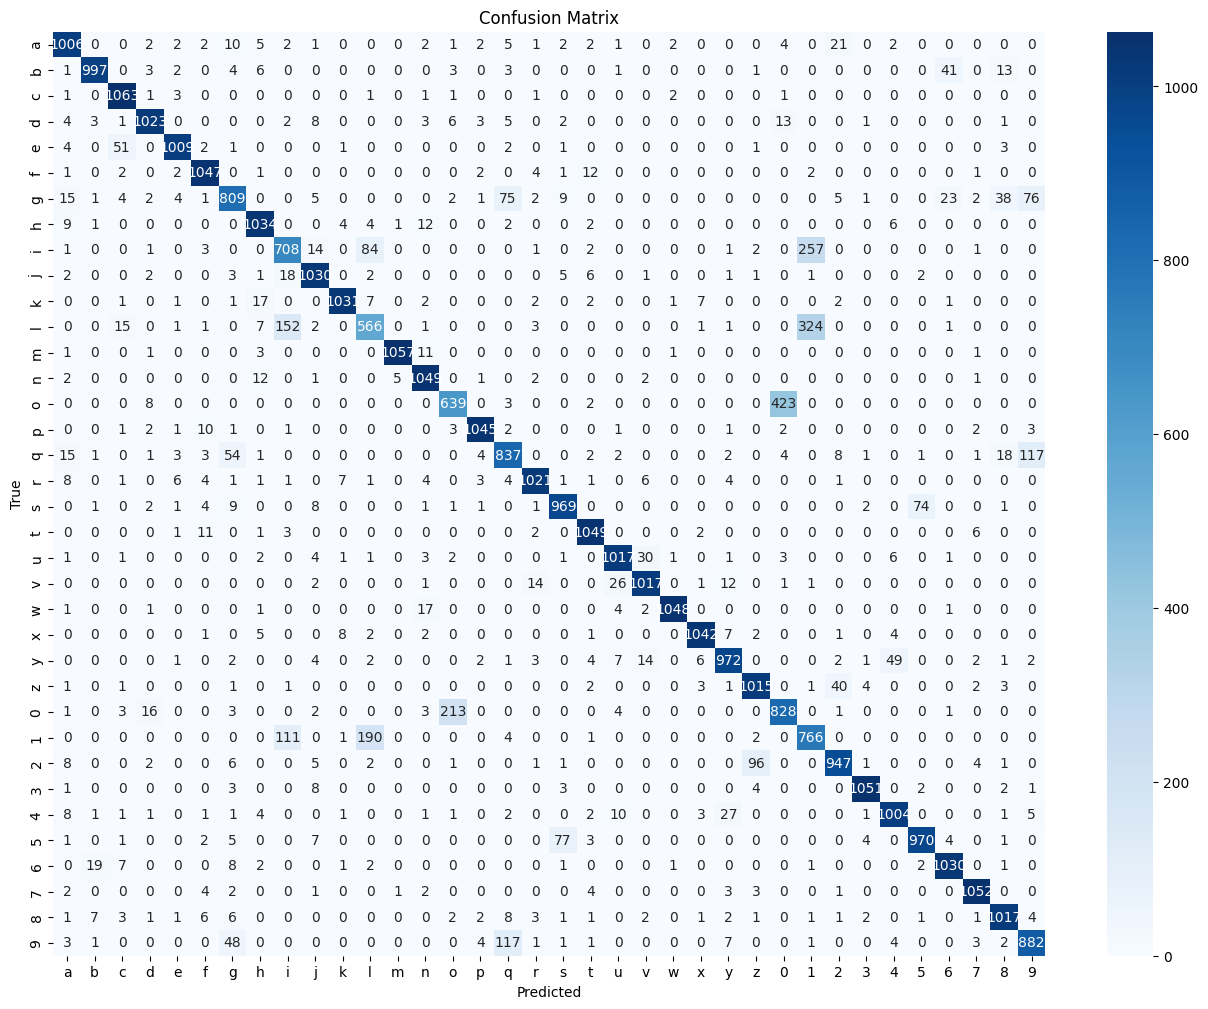

              precision    recall  f1-score   support

           a       0.92      0.94      0.93      1075
           b       0.97      0.93      0.95      1075
           c       0.92      0.99      0.95      1075
           d       0.96      0.95      0.95      1075
           e       0.97      0.94      0.96      1075
           f       0.95      0.97      0.96      1075
           g       0.83      0.75      0.79      1075
           h       0.94      0.96      0.95      1075
           i       0.71      0.66      0.68      1075
           j       0.93      0.96      0.95      1075
           k       0.98      0.96      0.97      1075
           l       0.66      0.53      0.58      1075
           m       0.99      0.98      0.99      1075
           n       0.94      0.98      0.96      1075
           o       0.73      0.59      0.66      1075
           p       0.98      0.97      0.97      1075
           q       0.78      0.78      0.78      1075
           r       0.96    

In [18]:
TrainEvalModel.evaluate_model(test_loader=dataset.test_loader, model=model1, classes=dataset.combined_classes)